In [1]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install detectron2==0.6 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html
# !pip install setuptools==59.5.0

In [2]:
import detectron2
import detectron2.data.transforms as T
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer

setup_logger()

import cv2
import os
import torch, torchvision
import matplotlib.pyplot as plt

In [3]:
DETECTRON_2_BASE_PATH = "/tf/datasets/final-dataset/detectron2-dataset"

DETECTRON_2_DATASET_PATHS = {
    "train": os.path.join(DETECTRON_2_BASE_PATH, "train"),
    "val": os.path.join(DETECTRON_2_BASE_PATH, "val"),
    "test": os.path.join(DETECTRON_2_BASE_PATH, "test"),
}

for subset in DETECTRON_2_DATASET_PATHS.keys():
    register_coco_instances(
        name=f"custom_dataset_{subset}",
        metadata={},
        json_file=os.path.join(
            DETECTRON_2_DATASET_PATHS[subset], "_annotations.coco.json"
        ),
        image_root=DETECTRON_2_DATASET_PATHS[subset],
    )

In [4]:
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(
            cfg,
            is_train=True,
            augmentations=[
                T.Resize((400, 400)),
                T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                T.RandomSaturation(intensity_min=0.8, intensity_max=1.2),
                T.RandomBrightness(intensity_min=0.8, intensity_max=1.2),
                T.RandomContrast(intensity_min=0.8, intensity_max=1.2),
            ],
        )
        return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_test_loader(cls, cfg, name="test"):
        mapper = DatasetMapper(
            cfg,
            is_train=False,
            augmentations=[T.Resize((400, 400))],
        )
        return build_detection_test_loader(cfg, name, mapper=mapper)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if not output_folder:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "validation")

        return COCOEvaluator(dataset_name, ("bbox",), False, output_folder)

Train

In [5]:
RUNS_PATH = "/tf/notebooks/CEIA/computer-vision-2/tp-final/runs"
TRAIN_PROJECT_PATH = os.path.join(RUNS_PATH, "train")

experiment = 'detectron2-rcnn-10000-epochs-no-lr-steps'
experimentPath =  os.path.join(TRAIN_PROJECT_PATH, experiment)

CONFIG_FILE = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE))
cfg.DATASETS.TRAIN = ("custom_dataset_train",)
cfg.DATASETS.TEST = ("custom_dataset_val",)
cfg.OUTPUT_DIR = experimentPath

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE)
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.MAX_ITER = 5000
# cfg.SOLVER.STEPS = (3000,)
# cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [6]:
torch.cuda.empty_cache() 

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [7]:
# run tensorboard
# !tensorboard --logdir=/tf/notebooks/CEIA/computer-vision-2/tp-final/runs/train --host 0.0.0.0

Test

In [8]:
trainer = CocoTrainer(cfg)
trainer.resume_or_load()

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("custom_dataset_test", ("bbox",), False, output_dir=os.path.join(cfg.OUTPUT_DIR, "test"))
mapper = DatasetMapper(cfg, is_train=False, augmentations=[T.Resize((400, 400))])
test_loader = build_detection_test_loader(cfg, "custom_dataset_test", mapper=mapper)
inference_on_dataset(trainer.model, test_loader, evaluator) 

Inference

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

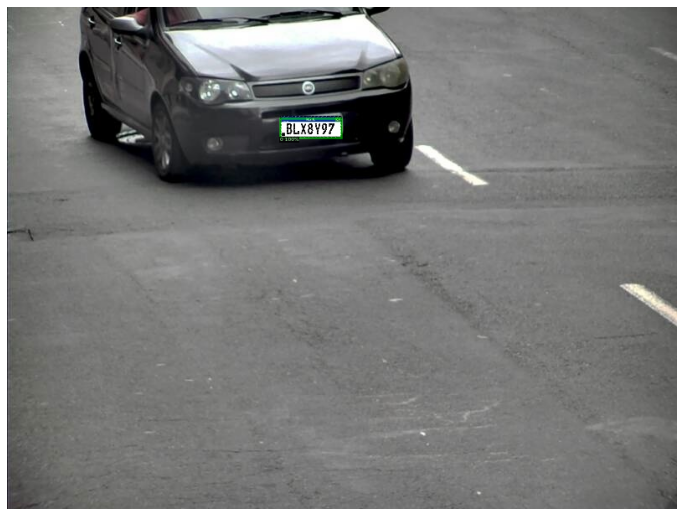

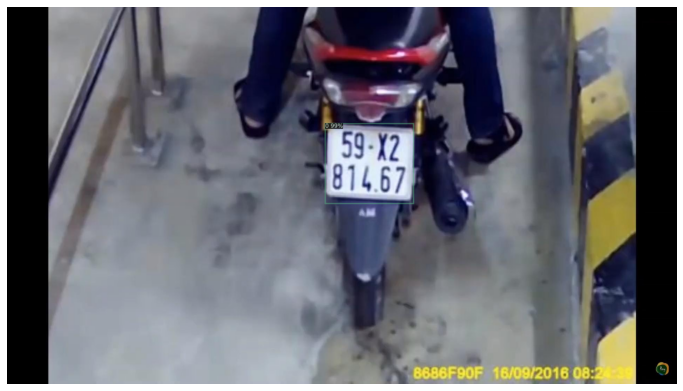

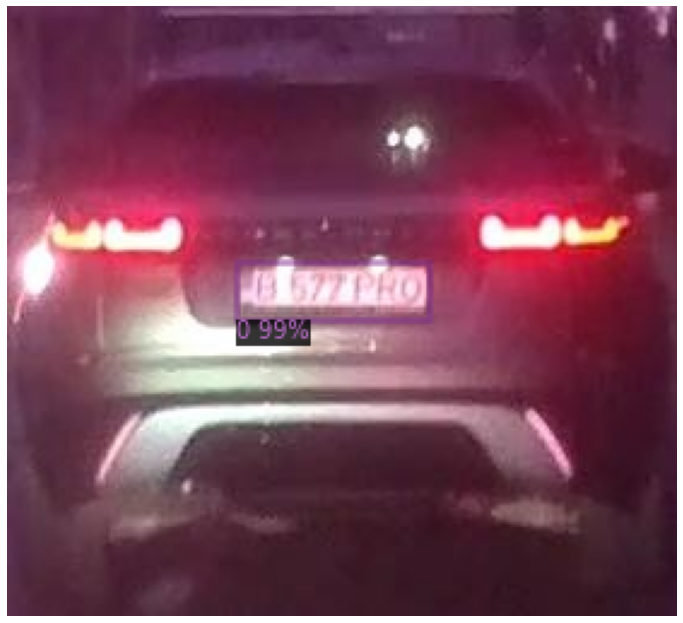

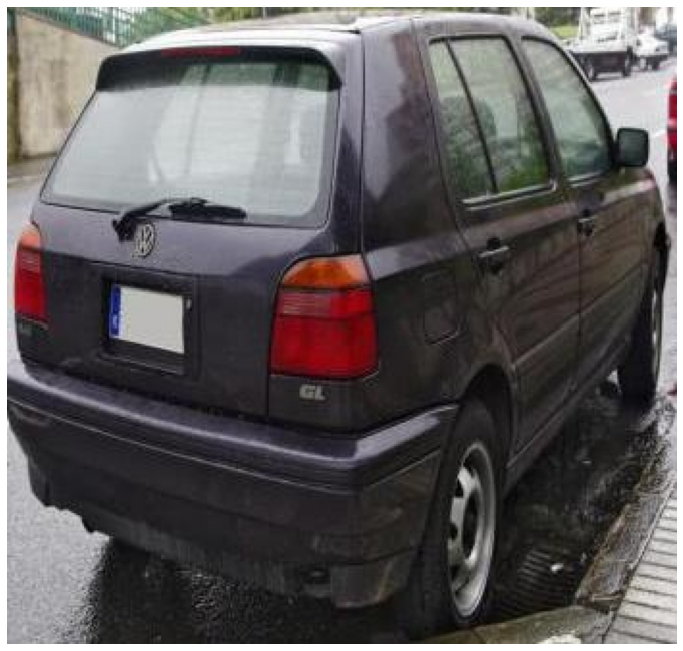

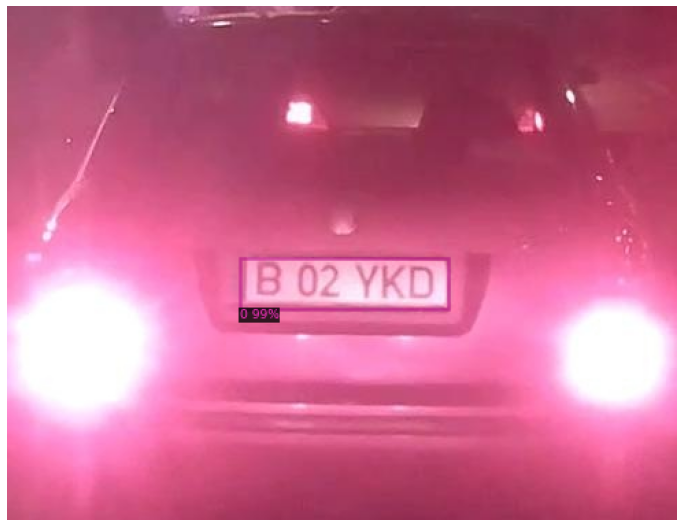

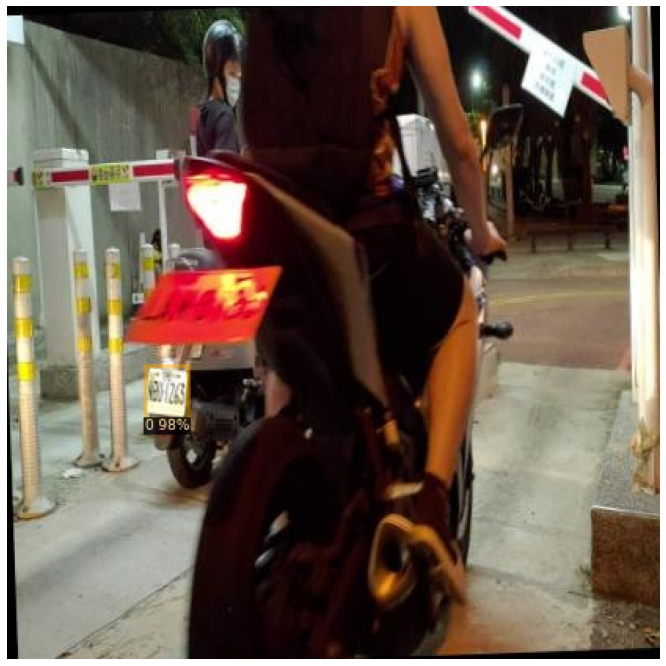

In [21]:
images = ["00097.jpg", "04870.jpg", "05966.jpg", "08037.jpg", "08608.jpg", "12926.jpg"]

for im_name in images:
    im_path = os.path.join(DETECTRON_2_DATASET_PATHS["test"], im_name)
    im = cv2.imread(im_path)

    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(12, 12))
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()